In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



## Download and Prepare the Dataset

Next, you will download the `plain_text` version of the `IMDB Reviews` dataset.

In [3]:
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

In [4]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [5]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

In [6]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## Model 1: Flatten

First up is simply using a `Flatten` layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

*Note: You might see a different graph in the lectures. This is because we adjusted the `BATCH_SIZE` for training so subsequent models will train faster.*

In [7]:
embedding_dim = 16
dense_dim = 6

model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_flatten.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
NUM_EPOCHS = 10
BATCH_SIZE =128


history_flatten = model_flatten.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 5s 23ms/step - loss: 0.4610 - accuracy: 0.8554 - val_loss: 0.4611 - val_accuracy: 0.8492
Epoch 2/10
196/196 [==============================] - 4s 20ms/step - loss: 0.3455 - accuracy: 0.9234 - val_loss: 0.4439 - val_accuracy: 0.8436
Epoch 3/10
196/196 [==============================] - 4s 18ms/step - loss: 0.2590 - accuracy: 0.9632 - val_loss: 0.4560 - val_accuracy: 0.8368
Epoch 4/10
196/196 [==============================] - 3s 17ms/step - loss: 0.2032 - accuracy: 0.9801 - val_loss: 0.4704 - val_accuracy: 0.8359
Epoch 5/10
196/196 [==============================] - 4s 22ms/step - loss: 0.1703 - accuracy: 0.9848 - val_loss: 0.4758 - val_accuracy: 0.8358
Epoch 6/10
196/196 [==============================] - 3s 17ms/step - loss: 0.1478 - accuracy: 0.9864 - val_loss: 0.4973 - val_accuracy: 0.8344
Epoch 7/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1314 - accuracy: 0.9871 - val_loss: 0.5111 - val_accuracy: 0.8333

In [ ]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

## LSTM

Next, you will use an LSTM. This is slower to train but useful in applications where the order of the tokens is important.

In [11]:
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                12544     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172941 (675.55 KB)
Trainable params: 172941 (675.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 47s 171ms/step - loss: 0.6129 - accuracy: 0.6723 - val_loss: 0.4858 - val_accuracy: 0.8359
Epoch 2/10
196/196 [==============================] - 44s 227ms/step - loss: 0.3612 - accuracy: 0.8528 - val_loss: 0.3850 - val_accuracy: 0.8327
Epoch 3/10
196/196 [==============================] - 32s 166ms/step - loss: 0.2743 - accuracy: 0.8933 - val_loss: 0.3770 - val_accuracy: 0.8408
Epoch 4/10
196/196 [==============================] - 37s 191ms/step - loss: 0.2239 - accuracy: 0.9170 - val_loss: 0.3786 - val_accuracy: 0.8388
Epoch 5/10
196/196 [==============================] - 28s 145ms/step - loss: 0.1946 - accuracy: 0.9300 - val_loss: 0.4586 - val_accuracy: 0.8222
Epoch 6/10
196/196 [==============================] - 30s 155ms/step - loss: 0.1656 - accuracy: 0.9434 - val_loss: 0.4406 - val_accuracy: 0.8278
Epoch 7/10
196/196 [==============================] - 28s 145ms/step - loss: 0.1428 - accuracy: 0.9527 - val_loss: 0.4811 - val_ac

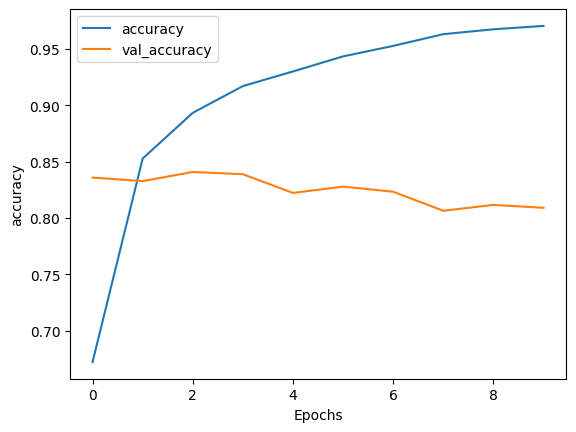

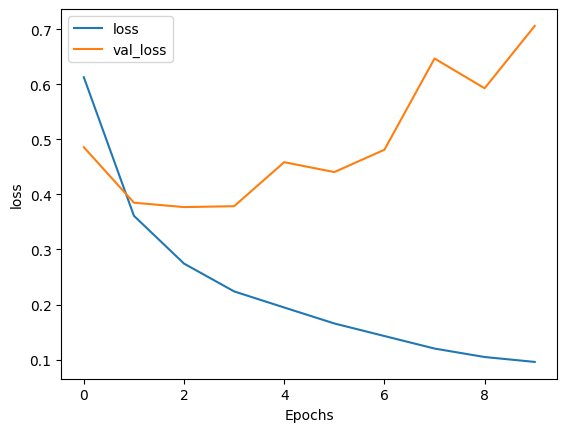

In [13]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

## GRU

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [14]:
# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 47s 165ms/step - loss: 0.6042 - accuracy: 0.6396 - val_loss: 0.4090 - val_accuracy: 0.8298
Epoch 2/10
196/196 [==============================] - 58s 296ms/step - loss: 0.3410 - accuracy: 0.8588 - val_loss: 0.3603 - val_accuracy: 0.8404
Epoch 3/10
196/196 [==============================] - 51s 260ms/step - loss: 0.2492 - accuracy: 0.9041 - val_loss: 0.3813 - val_accuracy: 0.8401
Epoch 4/10
196/196 [==============================] - 36s 183ms/step - loss: 0.1983 - accuracy: 0.9269 - val_loss: 0.4281 - val_accuracy: 0.8317
Epoch 5/10
196/196 [==============================] - 29s 148ms/step - loss: 0.1598 - accuracy: 0.9449 - val_loss: 0.4588 - val_accuracy: 0.8275
Epoch 6/10
196/196 [==============================] - 42s 213ms/step - loss: 0.1295 - accuracy: 0.9560 - val_loss: 0.4790 - val_accuracy: 0.8193
Epoch 7/10
196/196 [==============================] - 35s 179ms/step - loss: 0.0994 - accuracy: 0.9685 - val_loss: 0.5654 - val_ac

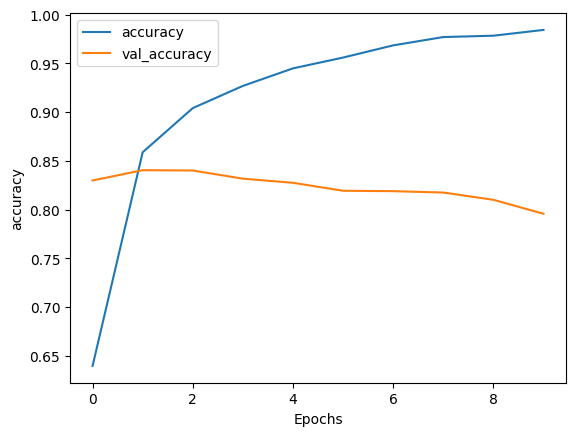

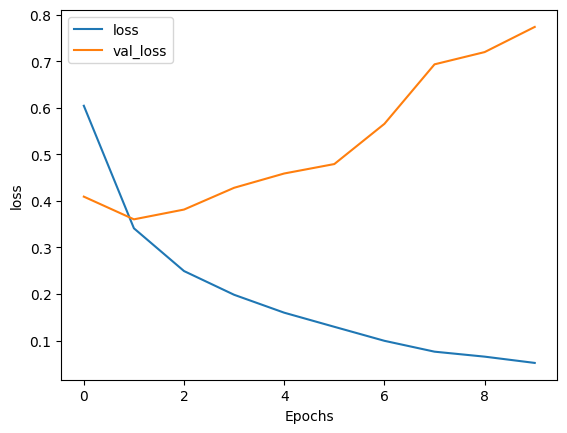

In [16]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

## Convolution

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1d](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [17]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [18]:
NUM_EPOCHS = 10
BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
196/196 [==============================] - 14s 54ms/step - loss: 0.5584 - accuracy: 0.7026 - val_loss: 0.3658 - val_accuracy: 0.8432
Epoch 2/10
196/196 [==============================] - 8s 39ms/step - loss: 0.3109 - accuracy: 0.8727 - val_loss: 0.3492 - val_accuracy: 0.8479
Epoch 3/10
196/196 [==============================] - 8s 39ms/step - loss: 0.2481 - accuracy: 0.9027 - val_loss: 0.3669 - val_accuracy: 0.8428
Epoch 4/10
196/196 [==============================] - 8s 39ms/step - loss: 0.2140 - accuracy: 0.9179 - val_loss: 0.4121 - val_accuracy: 0.8314
Epoch 5/10
196/196 [==============================] - 8s 39ms/step - loss: 0.1871 - accuracy: 0.9306 - val_loss: 0.4342 - val_accuracy: 0.8318
Epoch 6/10
196/196 [==============================] - 8s 40ms/step - loss: 0.1679 - accuracy: 0.9402 - val_loss: 0.4711 - val_accuracy: 0.8245
Epoch 7/10
196/196 [==============================] - 8s 42ms/step - loss: 0.1494 - accuracy: 0.9478 - val_loss: 0.5111 - val_accuracy: 0.819

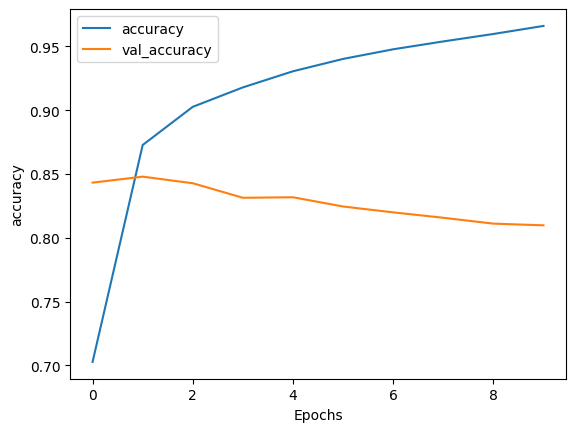

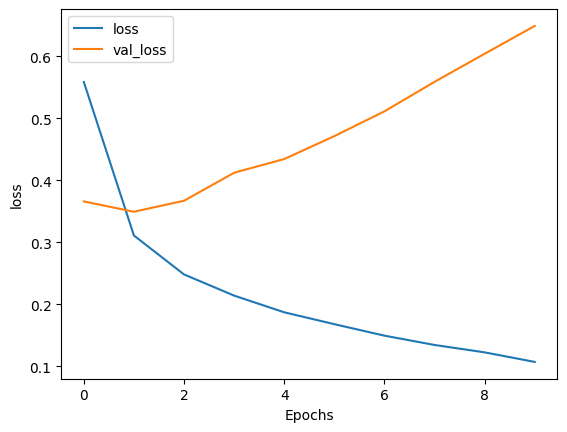

In [19]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')